# Quasilinear Diffusion operator

First attempt to calculate the QL diffusion based on a file from WKBeam.

Initially, only stored in rho and the components of N.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import QL_diff_aux as aux
from CommonModules.input_data import InputData 
from CommonModules.PlasmaEquilibrium import TokamakEquilibrium


In [2]:
eps = np.finfo(np.float32).eps

# electron mass
m_e         = 9.10938356e-31 # kg
# speed of light
c           = 299792458 # m/s
# electron charge
e           = 1.60217662e-19 # C
# momentum conversion
e_over_me_c2 = e / (m_e * c**2) 

In [3]:
#filename = '/home/devlamin/Documents/WKBeam_related/Cases_ran_before/TCV72644_1.25/No_fluct/output/L4_binned_QL.hdf5'
#filename = '/home/devlamin/WKBacca_LUKE_cases/TCV_74302/WKBeam_results/fluct/L1_binned_QL.hdf5'
filename = '/home/devlamin/WKBacca_LUKE_cases/TCV_85352_0.9/WKBeam_results/nofluct/L4_binned_QL_nonuni.hdf5'

filename_Eq = '/home/devlamin/WKBacca_QL/WKBacca_cases/TCV74302/L1_raytracing.txt'

In [4]:
WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rhobins, thetabins, Nparallelbins, Nperpbins = aux.read_h5file(filename)

In [5]:
print(Wfct.shape)

print(np.amax(Wfct))
print(np.mean(Wfct))

(20, 200, 100, 100, 2)
0.0030594305262897086
1.8843295963376529e-07


In [6]:
d_rho = np.diff(rhobins)
rho = 0.5 * (rhobins[1:] + rhobins[:-1])

psibins = rhobins**2
d_psi = np.diff(psibins)
psi = 0.5 * (psibins[1:] + psibins[:-1])

d_theta = np.diff(thetabins)[0]
theta = 0.5 * (thetabins[1:] + thetabins[:-1])

d_npar = np.diff(Nparallelbins)[0]
Npar = 0.5 * (Nparallelbins[1:] + Nparallelbins[:-1])

d_nperp = np.diff(Nperpbins)[0]
Nperp = 0.5 * (Nperpbins[1:] + Nperpbins[:-1])

idata = InputData(filename_Eq)
Eq = TokamakEquilibrium(idata)

dV_N = 2 * np.pi * Nperp * d_nperp * d_npar
ptV = np.zeros((len(rho), len(theta)))
R = np.zeros((len(rho), len(theta)))
Z = np.zeros((len(rho), len(theta)))

for l, psi_val in enumerate(psi):
    for t, theta_val in enumerate(theta):
        ptV[l, t] = 2*np.pi * 1e-6 * d_psi[l] * d_theta * Eq.volume_element_J(theta_val, psi_val)
        R[l, t], Z[l, t] = Eq.flux_to_grid_coord(psi_val, theta_val)
# As in notes, (called W_KB in the notes), we need Wfct * 4pi/c /(dV_N)
Edens =  Wfct[:,:,:,:,0] / np.sum(ptV, axis=1)[:, None, None, None]
Edens /= dV_N[None, None, None, :] # Energy density in k-space
Edens *= 4*np.pi /c * 1e6 
# With this, Edens_N is k-space energy density in J/N^2
#---Added factor for now to match C3PO output---#
Edens *= 2


 WARNING topfile: assuming psi = 1. at the separatrix. 



In [7]:
np.sum(d_psi)

0.9999999999999999

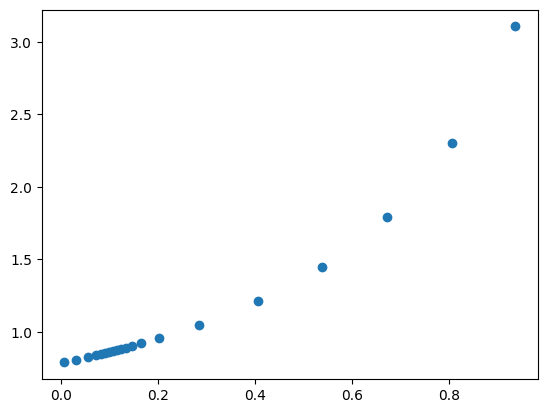

In [8]:
pV = np.sum(ptV, axis=1)
plt.figure()
plt.scatter(psi, pV/d_psi)

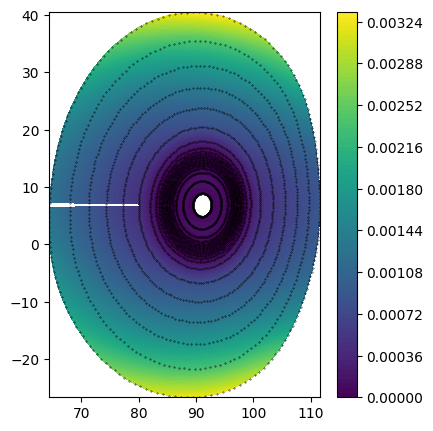

In [9]:

plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
vol = ax.contourf(R, Z, ptV, 100)
ax.scatter(R, Z, c='k', s=0.1)
plt.colorbar(vol)
ax.set_aspect('equal')


In [10]:
Abso = Absorption[:,:,:,:,0]
Abso /= ptV[:,:, None, None]
Abso/= dV_N[None, None, None, :]
Abso /= 2*np.pi

In [11]:
Wfct_maxdens = np.amax(Wfct)
Abso_maxdens = np.amax(Abso)
print('Wfct_maxdens:', Wfct_maxdens)
print('Abso_maxdens:', Abso_maxdens)

Wfct_maxdens: 0.0030594305262897086
Abso_maxdens: 36178.532784180636


In [12]:
Nparpar, Nperper = np.meshgrid(Npar, Nperp, indexing='ij')

N = np.sqrt(Nparpar**2 + Nperper**2)

/tmp/ipykernel_3356578/2128096298.py:3: RuntimeWarning: Mean of empty slice
  N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(theta))] for i in range(len(psi))])


Text(0.5, 1.0, 'Percentage of N-space filled')

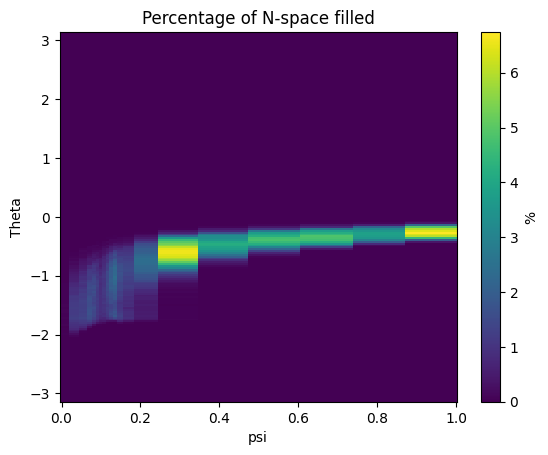

In [13]:
beam_mask = np.where(Wfct < 1e-4*Wfct_maxdens, False, True)

N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(theta))] for i in range(len(psi))])
N_avg_psi = np.nanmean(N_avg, axis=1)
percentage_filled = np.array([[N[beam_mask[i, j, :, :, 0]].shape[0] / N.size for j in range(len(theta))] for i in range(len(psi))])

fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.pcolormesh(psi, theta, 100*percentage_filled.T)

plt.colorbar(p1, label='%')
ax.set_xlabel('psi')
ax.set_ylabel('Theta')
ax.set_title('Percentage of N-space filled')



Text(0, 0.5, 'N_avg')

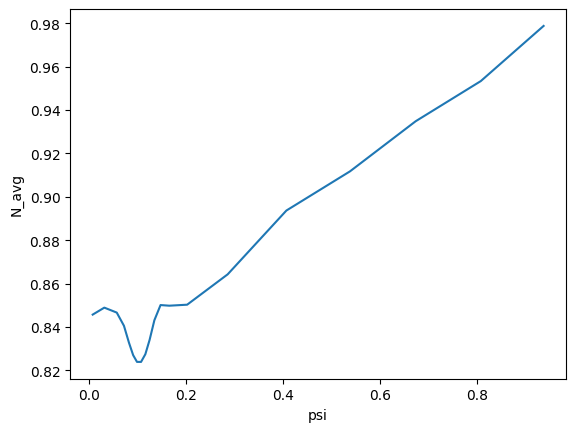

In [14]:
plt.plot(psi, N_avg_psi, label='N_avg')
plt.xlabel('psi')
plt.ylabel('N_avg')

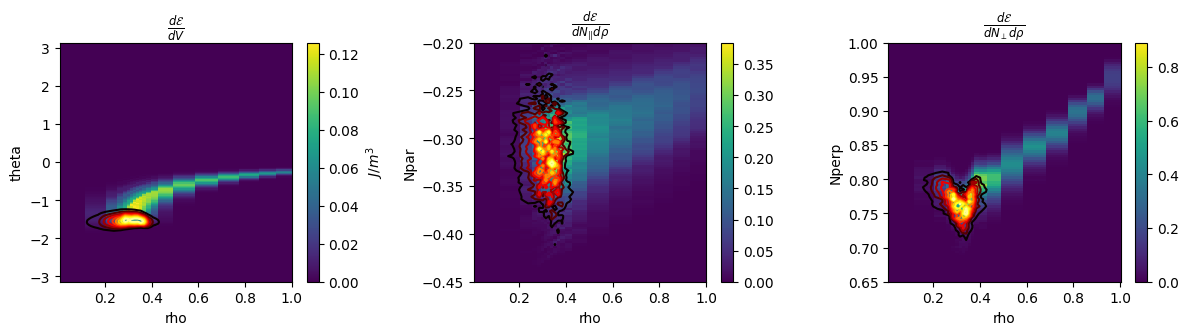

In [15]:
Edens_rho_Theta = np.sum(Edens*dV_N[None, None, None, :], axis=(2, 3))
Abs_rho_Theta = np.sum(Abso*dV_N[None, None, None, :], axis=(2, 3))
Abs_rho_Theta_max = np.amax(Abs_rho_Theta)

Edens_rho_Nparallel = np.sum(Edens*2*np.pi*d_nperp*rho[:, None, None, None]*d_theta*Nperp[None, None, None, :], axis=(1, 3))
Abs_rho_Nparallel = np.sum(Abso*2*np.pi*d_nperp*rho[:, None, None, None]*d_theta*Nperp[None, None, None, :], axis=(1, 3))
Abs_rho_Nparallel_max = np.amax(Abs_rho_Nparallel)

Edens_rho_Nperp = np.sum(Edens*2*np.pi*d_npar*rho[:, None, None, None]*d_theta, axis=(1, 2))
Abs_rho_Nperp = np.sum(Abso*2*np.pi*d_npar*rho[:, None, None, None]*d_theta, axis=(1, 2))
Abs_rho_Nperp_max = np.amax(Abs_rho_Nperp)


plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 3, 1)
plot1 = ax1.pcolormesh(rho, theta, Edens_rho_Theta.T)#, norm=LogNorm())
plt.colorbar(plot1, label=r'$J/m^3$')
ax1.contour(rho, theta, Abs_rho_Theta.T, levels=np.linspace(Abs_rho_Theta_max/10, Abs_rho_Theta_max, 10), cmap='hot')
#ax1.set_facecolor('white')
ax1.set_xlabel('rho')
ax1.set_ylabel('theta')
ax1.set_title(r'$\frac{d\mathcal{E}}{dV}$')


ax2 = plt.subplot(2, 3, 2)
plot2 = ax2.pcolormesh(rho, Npar, Edens_rho_Nparallel.T)#, norm=LogNorm())
plt.colorbar(plot2)
ax2.contour(rho, Npar, Abs_rho_Nparallel.T, levels=np.linspace(Abs_rho_Nparallel_max/10, Abs_rho_Nparallel_max, 10), cmap='hot')
ax2.set_xlabel('rho')
ax2.set_ylabel('Npar')
ax2.set_title(r'$\frac{d\mathcal{E}}{dN_{||}d\rho}$')

ax3 = plt.subplot(2, 3, 3)
plot3 = ax3.pcolormesh(rho, Nperp, Edens_rho_Nperp.T)#, norm=LogNorm())
plt.colorbar(plot3)
ax3.contour(rho, Nperp, Abs_rho_Nperp.T, levels=np.linspace(Abs_rho_Nperp_max/10, Abs_rho_Nperp_max, 10), cmap='hot')
ax3.set_xlabel('rho')
ax3.set_ylabel('Nperp')
ax3.set_title(r'$\frac{d\mathcal{E}}{dN_{\perp}d\rho}$')

plt.tight_layout()
plt.show()


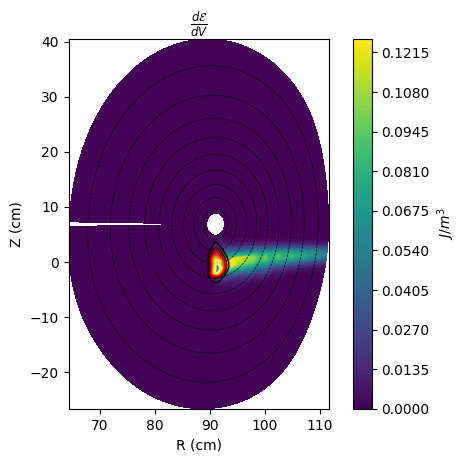

In [16]:
plt.figure()
ax = plt.subplot(111)
beam = ax.contourf(R, Z, Edens_rho_Theta, 100)
PSI = np.tile(psi, (len(theta), 1)).T
RHO = np.tile(rho, (len(theta), 1)).T
ax.contour(R, Z, RHO, levels=10, colors='k', linestyles='dashed', linewidths=0.5)
ax.contour(R, Z, Abs_rho_Theta, levels=np.linspace(Abs_rho_Theta_max/10, Abs_rho_Theta_max, 10), cmap='hot', linestyles='-', linewidths=1)
plt.colorbar(beam, label=r'$J/m^3$')
ax.set_aspect('equal')
ax.set_xlabel('R (cm)')
ax.set_ylabel('Z (cm)')
ax.set_title(r'$\frac{d\mathcal{E}}{dV}$')

plt.show()
